In [50]:
import pandas as pd 
df = pd.read_csv("Telco-Customer-Churn.csv")
print(df.columns.tolist())
df.columns = df.columns.str.strip().str.lower()
print(df.columns.tolist())


['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn']


In [51]:
from sklearn.model_selection import train_test_split 
import numpy as np

# Normalize column names too
df.columns = df.columns.str.strip().str.lower()

# FIX: after lowercasing, it's "customerid"
if "customerid" in df.columns:
    df = df.drop(columns=["customerid"])

# Strip whitespace on ALL string columns (avoids "No " vs "No")
obj_cols = df.select_dtypes(include="object").columns
df[obj_cols] = df[obj_cols].apply(lambda s: s.str.strip())

# Normalize case on ALL string columns (so "YES", "Yes", "yes" are identical)
df[obj_cols] = df[obj_cols].apply(lambda s: s.str.lower())

# FIX: convert empty strings to NaN (prevents dataset wipe)
df.replace("", np.nan, inplace=True)

print(df.columns.tolist())

# Convert TotalCharges
if "totalcharges" in df.columns:
    df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors="coerce")

assert "churn" in df.columns, "Expected 'Churn' column not found."

# Keep only valid churn values
df = df[df["churn"].isin(["yes", "no"])].copy()

# Encode target
df["churn"] = df["churn"].map({"yes": 1, "no": 0})

# Check missing
missing_before = df.isna().sum().sum()

# Handling missing data
df = df.dropna().reset_index(drop=True)

missing_after = df.isna().sum().sum()

# Final X, y
X = df.drop(columns=["churn"])
y = df["churn"]

print("Shape:", df.shape)
print("Missing values removed:", missing_before - missing_after)
print("Target balance (churn rate):")
print(y.value_counts(normalize=True).rename({0: "no", 1: "yes"}))
print("\nSample rows:")
print(df.head(3))


['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn']
Shape: (7032, 20)
Missing values removed: 11
Target balance (churn rate):
churn
no     0.734215
yes    0.265785
Name: proportion, dtype: float64

Sample rows:
   gender  seniorcitizen partner dependents  tenure phoneservice  \
0  female              0     yes         no       1           no   
1    male              0      no         no      34          yes   
2    male              0      no         no       2          yes   

      multiplelines internetservice onlinesecurity onlinebackup  \
0  no phone service             dsl             no          yes   
1                no             dsl            yes           no   
2                no             dsl            yes       

In [52]:
#train/validation and /test split
from sklearn.model_selection import train_test_split 

#split into train temp and test
#here first spplit in to temp = 40 =% and train  = 60%
x_train,x_temp,y_train,y_temp = train_test_split(X,y,test_size = 0.4,stratify=y,random_state = 42)
#split the data into noe test and validation from temp data
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size = 0.5,stratify=y_temp,random_state=42)
print("Train:",x_train.shape,y_train.mean())
print("val:",x_val.shape,y_val.mean())
print("Test: ",x_test.shape,y_test.mean())

Train: (4219, 19) 0.2657027731689974
val: (1406, 19) 0.26600284495021337
Test:  (1407, 19) 0.2658137882018479


In [53]:
#base model which  is good and nml 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import( accuracy_score, precision_score,recall_score,f1_score,roc_auc_score, confusion_matrix)
import numpy as np
def eva_baseline(model,x_val,y_val,name = ""):
    y_pred = model.predict(x_val)
    # For ROC-AUC we need probabilities; handle models that don't expose predict_proba (most_frequent)
    roc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_val)[:, 1]
        roc = roc_auc_score(y_val, y_proba)
    acc = accuracy_score(y_val,y_pred)
    prec = precision_score(y_val,y_pred, zero_division = 0)
    rec = recall_score(y_val,y_pred,zero_division = 0)
    f1 = f1_score(y_val,y_pred,zero_division = 0)
    cm  = confusion_matrix(y_val,y_pred)

    print(f"\n === {name} ===")
    print("Accuracy :", round(acc,3))
    print("Precision: ",round(prec,3))
    print("recall: ",round(rec,3))
    print("F1 : ",round(f1,3))
    if roc is not None:
       print("ROC_AUC : ", round(roc,3))
    print("confusion_matrix:\n",cm)
# majority basline always predict the modt frequent class("no churn")
dummy_majority = DummyClassifier(strategy = "most_frequent")
dummy_majority.fit(x_train,y_train)
eva_baseline(dummy_majority,x_val,y_val,name="Majority (most_frequent)")
# random baseline predict according to class distribution 
dummy_random = DummyClassifier(strategy = "stratified", random_state = 42)
dummy_random.fit(x_train,y_train)
eva_baseline(dummy_random,x_val,y_val,name = "random(stratified)")




 === Majority (most_frequent) ===
Accuracy : 0.734
Precision:  0.0
recall:  0.0
F1 :  0.0
ROC_AUC :  0.5
confusion_matrix:
 [[1032    0]
 [ 374    0]]

 === random(stratified) ===
Accuracy : 0.605
Precision:  0.259
recall:  0.259
F1 :  0.259
ROC_AUC :  0.495
confusion_matrix:
 [[754 278]
 [277  97]]


In [54]:
#Our real model Preprocessing + logictic regression 
from sklearn.preprocessing import  OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ( accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix)
import numpy as np 

#identify numerical and categorical  columns
categorical_cols = x_train.select_dtypes(include = ["object"]).columns.tolist()
numeric_cols = x_train.select_dtypes(exclude = ["object"]).columns.tolist()
print("categorical features: ",categorical_cols)
print("Numeric_features: ", numeric_cols)
#preprocessor ONe hot  for categoricals scale for numerics
preprocessor = ColumnTransformer(transformers = [("cat", OneHotEncoder(handle_unknown = "ignore"),categorical_cols),("num",StandardScaler(),numeric_cols)])
# build pipeline
pipe = Pipeline(steps = [("preprocess",preprocessor),("logreg",LogisticRegression(max_iter = 1000,class_weight ="balanced", solver = "lbfgs"))])

#value of C for regularization 
param_grid = {"logreg__C":[0.01,0.1,0.5,1 ,3, 10]}
grid = GridSearchCV(pipe,param_grid,scoring = "roc_auc",cv = 5,n_jobs = -1)

#fit on the train set 
grid.fit(x_train,y_train)
print("Best C:",grid.best_params_["logreg__C"])
print("Best cv ROC-AUC (train):", round(grid.best_score_,3))

#Evaluate on validation  set 
best_model = grid.best_estimator_
y_pred = best_model.predict(x_val)
y_proba = best_model.predict_proba(x_val)[:, 1]

print("\n === validation results ===")
print("Accuracy :", round(accuracy_score(y_val,y_pred),3))
print("Precision:",round(precision_score(y_val,y_pred),3))
print("Recall: ",round(recall_score(y_val, y_pred),3 ))
print("F1 :",round(f1_score(y_val,y_pred),3))
print("Roc_auc :",round(roc_auc_score(y_val,y_proba),3))

cm = confusion_matrix(y_val,y_pred)
print("cofusion Matrix:\n", cm)



categorical features:  ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
Numeric_features:  ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']
Best C: 10
Best cv ROC-AUC (train): 0.846

 === validation results ===
Accuracy : 0.733
Precision: 0.499
Recall:  0.797
F1 : 0.614
Roc_auc : 0.834
cofusion Matrix:
 [[733 299]
 [ 76 298]]


In [55]:
#comparing the Pipeline 
#majority baseline on val 
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy = "most_frequent")
dummy_majority.fit(x_train,y_train)
maj_acc = accuracy_score(y_val,dummy_majority.predict(x_val))

# random baseline on val
dummy_random = DummyClassifier(strategy = "stratified", random_state = 42)
dummy_random.fit(x_train,y_train)
rand_acc = accuracy_score(y_val,dummy_random.predict(x_val))
rand_roc = roc_auc_score(y_val,dummy_random.predict_proba(x_val)[:,1])

print("Majority baseline acc:", round(maj_acc,3), "| recall:", recall_score(y_val, dummy_majority.predict(x_val)))
print("Random baseline acc  :", round(rand_acc,3), "| roc-auc:", round(rand_roc,3))

# logistic regression results already computed earlier
print("Logistic ROC-AUC:", round(roc_auc_score(y_val, y_proba),3))
print("Logistic Recall :", round(recall_score(y_val, y_pred),3))
print("Logistic Acc    :", round(accuracy_score(y_val, y_pred),3))


Majority baseline acc: 0.734 | recall: 0.0
Random baseline acc  : 0.605 | roc-auc: 0.495
Logistic ROC-AUC: 0.834
Logistic Recall : 0.797
Logistic Acc    : 0.733


Refitting final model with C = 10

FINAL TEST RESULTS: 
Accuracy : 0.739
Precision: 0.506
Recall  : 0.829
F1 : 0.628
ROC-AUC : 0.847
Confusion Matrix:
 [[730 303]
 [ 64 310]]


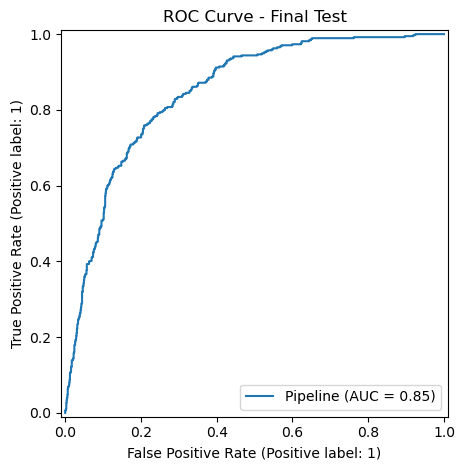

In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, RocCurveDisplay)
import numpy as np
import matplotlib.pyplot as plt

#Combine train +val
x_tv = pd.concat([x_train,x_val],axis = 0).reset_index(drop=True)
y_tv = pd.concat([y_train,y_val],axis = 0).reset_index(drop=True)

# rebuild the same preprocessor(cat one-hot+num scale)
categorical_cols = x_tv.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = x_tv.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),("num", StandardScaler(), numeric_cols)])
#Use best C from your previous GridSearch on validation
best_C = grid.best_params_["logreg__C"]  # from Step 6
print("Refitting final model with C =", best_C)


#final model
final_model = Pipeline(steps = [("preprocess",preprocessor),("logreg",LogisticRegression(max_iter = 1000,class_weight = "balanced",solver = "lbfgs",C=best_C))] )

# fit on train +val
final_model.fit(x_tv,y_tv)

# Evaluate ONCE on the untouched Test set
y_pred_test  = final_model.predict(x_test)
y_proba_test = final_model.predict_proba(x_test)[:, 1]

acc  = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, zero_division=0)
rec  = recall_score(y_test, y_pred_test, zero_division=0)
f1   = f1_score(y_test, y_pred_test, zero_division=0)
auc  = roc_auc_score(y_test, y_proba_test)
cm   = confusion_matrix(y_test, y_pred_test)

print("\nFINAL TEST RESULTS: ")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall  :", round(rec, 3))
print("F1 :", round(f1, 3))
print("ROC-AUC :", round(auc, 3))
print("Confusion Matrix:\n", cm)

#  Show ROC curve for the test set
RocCurveDisplay.from_estimator(final_model, x_test, y_test)
plt.title("ROC Curve - Final Test")
plt.tight_layout()
plt.show()